# Assign DipC cells to RNA clusters

In [1]:
import time
import numpy as np
import pandas as pd
from glob import glob
import anndata
import scanpy as sc
import scanpy.external as sce
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm as cm
import seaborn as sns
from scipy.sparse import csr_matrix
from ALLCools.plot import *
from ALLCools.clustering import *
from ALLCools.integration.seurat_class import SeuratIntegration
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize, OneHotEncoder
import pynndescent

mpl.style.use('default')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Helvetica'


In [2]:
gene_hdf = pd.read_hdf(f'/data/test_schicluster/Tan2021/scool/dataset/Tan2021.geneimputescore.hdf', key='data')


In [3]:
res = 10000
gene_meta_path = '/data/ref/mm10/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz'
gene_meta = pd.read_csv(gene_meta_path, index_col='gene_id', sep='\t')
gene_meta['bin_len'] = (gene_meta['end'] // res) - (gene_meta['start'] // res) + 1
#gene_meta['weight'] = gene_meta['bin_len'] * (gene_meta['bin_len'] + 1) / 2
gene_meta['weight'] = (gene_meta['bin_len']+2) * (gene_meta['bin_len'] + 1) / 2
#gene_meta['weight'] = gene_meta['bin_len'].copy()



In [4]:
indir = '/home/jzhou_salk_edu/sky_workdir/test_schicluster/Tan2021/'


In [5]:
chrom_size_path = '/data/ref/mm10/genome/mm10.main.chrom.sizes'
chromsize = pd.read_csv(chrom_size_path, sep='\t', header=None, index_col=0)
gene_meta = gene_meta[gene_meta['chrom'].isin(chromsize.index)]
gene_meta


chrom   source feature    start      end score strand  \
gene_id                                                                      
ENSMUSG00000102693.1  chr1   HAVANA    gene  3073253  3074322     .      +   
ENSMUSG00000064842.1  chr1  ENSEMBL    gene  3102016  3102125     .      +   
ENSMUSG00000051951.5  chr1   HAVANA    gene  3205901  3671498     .      -   
ENSMUSG00000102851.1  chr1   HAVANA    gene  3252757  3253236     .      +   
ENSMUSG00000103377.1  chr1   HAVANA    gene  3365731  3368549     .      -   
...                    ...      ...     ...      ...      ...   ...    ...   
ENSMUSG00000064368.1  chrM  ENSEMBL    gene    13552    14070     .      -   
ENSMUSG00000064369.1  chrM  ENSEMBL    gene    14071    14139     .      -   
ENSMUSG00000064370.1  chrM  ENSEMBL    gene    14145    15288     .      +   
ENSMUSG00000064371.1  chrM  ENSEMBL    gene    15289    15355     .      +   
ENSMUSG00000064372.1  chrM  ENSEMBL    gene    15356    15422     .      -   

                     phase  transcript_id             gene_type  ...  \
gene_id                                                          ...   
ENSMUSG00000102693.1     .            NaN                   TEC  ...   
ENSMUSG00000064842.1     .            NaN                 snRNA  ...   
ENSMUSG00000051951.5     .            NaN        protein_coding  ...   
ENSMUSG00000102851.1     .            NaN  processed_pseudogene  ...   
ENSMUSG00000103377.1     .            NaN                   TEC  ...   
...                    ...            ...                   ...  ...   
ENSMUSG00000064368.1     .            NaN        protein_coding  ...   
ENSMUSG00000064369.1     .            NaN               Mt_tRNA  ...   
ENSMUSG00000064370.1     .            NaN        protein_coding  ...   
ENSMUSG00000064371.1     .            NaN               Mt_tRNA  ...   
ENSMUSG00000064372.1     .            NaN               Mt_tRNA  ...   

                      transcript_status transcript_name  exon_number  exon_id  \
gene_id                                                                         
ENSMUSG00000102693.1                NaN             NaN          NaN      NaN   
ENSMUSG00000064842.1                NaN             NaN          NaN      NaN   
ENSMUSG00000051951.5                NaN             NaN          NaN      NaN   
ENSMUSG00000102851.1                NaN             NaN          NaN      NaN   
ENSMUSG00000103377.1                NaN             NaN          NaN      NaN   
...                                 ...             ...          ...      ...   
ENSMUSG00000064368.1                NaN             NaN          NaN      NaN   
ENSMUSG00000064369.1                NaN             NaN          NaN      NaN   
ENSMUSG00000064370.1                NaN             NaN          NaN      NaN   
ENSMUSG00000064371.1                NaN             NaN          NaN      NaN   
ENSMUSG00000064372.1                NaN             NaN          NaN      NaN   

                      level       mgi_id           havana_gene  \
gene_id                                                          
ENSMUSG00000102693.1      2  MGI:1918292  OTTMUSG00000049935.1   
ENSMUSG00000064842.1      3  MGI:5455983                   NaN   
ENSMUSG00000051951.5      2  MGI:3528744  OTTMUSG00000026353.2   
ENSMUSG00000102851.1      1  MGI:5011141  OTTMUSG00000049958.1   
ENSMUSG00000103377.1      2  MGI:5610408  OTTMUSG00000049960.1   
...                     ...          ...                   ...   
ENSMUSG00000064368.1      3   MGI:102495                   NaN   
ENSMUSG00000064369.1      3   MGI:102488                   NaN   
ENSMUSG00000064370.1      3   MGI:102501                   NaN   
ENSMUSG00000064371.1      3   MGI:102473                   NaN   
ENSMUSG00000064372.1      3   MGI:102478                   NaN   

                                 tag bin_len  weight  
gene_id                                               
ENSMUSG00000102693.1             NaN       1  

In [6]:
#gene_hdf = gene_hdf * gene_meta.loc[gene_hdf.columns, 'weight']
(gene_hdf>0).sum(axis=1)


cortex-p001-cb_034         39820
cortex-p001-cb_025         44877
cortex-p001-cb_119         48588
cortex-p001-cb_009         49538
cortex-p001-cb_005         49383
                           ...  
hippocampus-p347-cb_166    50257
hippocampus-p347-cb_191    49946
hippocampus-p347-cb_178    50059
hippocampus-p347-cb_187    49801
hippocampus-p347-cb_188    50075
Length: 3646, dtype: int64

In [7]:
adata = anndata.read_h5ad(f'{indir}Tan2021_dipc.h5ad')
adata

AnnData object with n_obs × n_vars = 3646 × 1
    obs: 'tissue', 'treatment', 'age', 'sex', 'father', 'mother', 'restriction enzyme', 'cell-type cluster', 'contacts', 'umap_0', 'umap_1', 'leiden'
    uns: 'leiden', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'dipc_pca_all'
    obsp: 'connectivities', 'distances'

In [8]:
gene3c = anndata.AnnData(gene_hdf.loc[adata.obs.index], obs=adata.obs, var=gene_meta.loc[gene_hdf.columns])
gene3c


AnnData object with n_obs × n_vars = 3646 × 51259
    obs: 'tissue', 'treatment', 'age', 'sex', 'father', 'mother', 'restriction enzyme', 'cell-type cluster', 'contacts', 'umap_0', 'umap_1', 'leiden'
    var: 'chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'phase', 'transcript_id', 'gene_type', 'gene_status', 'gene_name', 'transcript_type', 'transcript_status', 'transcript_name', 'exon_number', 'exon_id', 'level', 'mgi_id', 'havana_gene', 'tag', 'bin_len', 'weight'

In [9]:
chrom_to_remove = ['chrL', 'chrM', 'chrX', 'chrY']
chrfilter = ~gene3c.var['chrom'].isin(chrom_to_remove)
gene3c = gene3c[:, chrfilter]


In [10]:
genefilter = ((gene3c.X>0).sum(axis=0)>10)
gene3c = gene3c[:, genefilter]
gene3c


View of AnnData object with n_obs × n_vars = 3646 × 51097
    obs: 'tissue', 'treatment', 'age', 'sex', 'father', 'mother', 'restriction enzyme', 'cell-type cluster', 'contacts', 'umap_0', 'umap_1', 'leiden'
    var: 'chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'phase', 'transcript_id', 'gene_type', 'gene_status', 'gene_name', 'transcript_type', 'transcript_status', 'transcript_name', 'exon_number', 'exon_id', 'level', 'mgi_id', 'havana_gene', 'tag', 'bin_len', 'weight'

In [11]:
gene3c.var.index.name = 'gene_id'


In [12]:
gene3c.raw = gene3c.copy()
#sc.pp.highly_variable_genes(gene3c, n_top_genes=2000, flavor='seurat_v3')
gene3c.write_h5ad(f'cell_{gene3c.shape[0]}_gene3C.h5ad')


In [13]:
# gene3c = anndata.read_h5ad(f'{indir}cell_8225_gene3C_impute.h5ad')
gene3c = anndata.read_h5ad(glob(f'cell_*_gene3C.h5ad')[0])
gene3c

AnnData object with n_obs × n_vars = 3646 × 51097
    obs: 'tissue', 'treatment', 'age', 'sex', 'father', 'mother', 'restriction enzyme', 'cell-type cluster', 'contacts', 'umap_0', 'umap_1', 'leiden'
    var: 'chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'phase', 'transcript_id', 'gene_type', 'gene_status', 'gene_name', 'transcript_type', 'transcript_status', 'transcript_name', 'exon_number', 'exon_id', 'level', 'mgi_id', 'havana_gene', 'tag', 'bin_len', 'weight'

In [14]:
gene_meta

chrom   source feature    start      end score strand  \
gene_id                                                                      
ENSMUSG00000102693.1  chr1   HAVANA    gene  3073253  3074322     .      +   
ENSMUSG00000064842.1  chr1  ENSEMBL    gene  3102016  3102125     .      +   
ENSMUSG00000051951.5  chr1   HAVANA    gene  3205901  3671498     .      -   
ENSMUSG00000102851.1  chr1   HAVANA    gene  3252757  3253236     .      +   
ENSMUSG00000103377.1  chr1   HAVANA    gene  3365731  3368549     .      -   
...                    ...      ...     ...      ...      ...   ...    ...   
ENSMUSG00000064368.1  chrM  ENSEMBL    gene    13552    14070     .      -   
ENSMUSG00000064369.1  chrM  ENSEMBL    gene    14071    14139     .      -   
ENSMUSG00000064370.1  chrM  ENSEMBL    gene    14145    15288     .      +   
ENSMUSG00000064371.1  chrM  ENSEMBL    gene    15289    15355     .      +   
ENSMUSG00000064372.1  chrM  ENSEMBL    gene    15356    15422     .      -   

                     phase  transcript_id             gene_type  ...  \
gene_id                                                          ...   
ENSMUSG00000102693.1     .            NaN                   TEC  ...   
ENSMUSG00000064842.1     .            NaN                 snRNA  ...   
ENSMUSG00000051951.5     .            NaN        protein_coding  ...   
ENSMUSG00000102851.1     .            NaN  processed_pseudogene  ...   
ENSMUSG00000103377.1     .            NaN                   TEC  ...   
...                    ...            ...                   ...  ...   
ENSMUSG00000064368.1     .            NaN        protein_coding  ...   
ENSMUSG00000064369.1     .            NaN               Mt_tRNA  ...   
ENSMUSG00000064370.1     .            NaN        protein_coding  ...   
ENSMUSG00000064371.1     .            NaN               Mt_tRNA  ...   
ENSMUSG00000064372.1     .            NaN               Mt_tRNA  ...   

                      transcript_status transcript_name  exon_number  exon_id  \
gene_id                                                                         
ENSMUSG00000102693.1                NaN             NaN          NaN      NaN   
ENSMUSG00000064842.1                NaN             NaN          NaN      NaN   
ENSMUSG00000051951.5                NaN             NaN          NaN      NaN   
ENSMUSG00000102851.1                NaN             NaN          NaN      NaN   
ENSMUSG00000103377.1                NaN             NaN          NaN      NaN   
...                                 ...             ...          ...      ...   
ENSMUSG00000064368.1                NaN             NaN          NaN      NaN   
ENSMUSG00000064369.1                NaN             NaN          NaN      NaN   
ENSMUSG00000064370.1                NaN             NaN          NaN      NaN   
ENSMUSG00000064371.1                NaN             NaN          NaN      NaN   
ENSMUSG00000064372.1                NaN             NaN          NaN      NaN   

                      level       mgi_id           havana_gene  \
gene_id                                                          
ENSMUSG00000102693.1      2  MGI:1918292  OTTMUSG00000049935.1   
ENSMUSG00000064842.1      3  MGI:5455983                   NaN   
ENSMUSG00000051951.5      2  MGI:3528744  OTTMUSG00000026353.2   
ENSMUSG00000102851.1      1  MGI:5011141  OTTMUSG00000049958.1   
ENSMUSG00000103377.1      2  MGI:5610408  OTTMUSG00000049960.1   
...                     ...          ...                   ...   
ENSMUSG00000064368.1      3   MGI:102495                   NaN   
ENSMUSG00000064369.1      3   MGI:102488                   NaN   
ENSMUSG00000064370.1      3   MGI:102501                   NaN   
ENSMUSG00000064371.1      3   MGI:102473                   NaN   
ENSMUSG00000064372.1      3   MGI:102478                   NaN   

                                 tag bin_len  weight  
gene_id                                               
ENSMUSG00000102693.1             NaN       1  

In [15]:
gene3c.var.index = gene_meta.loc[gene3c.var.index, 'gene_name']
gene3c.var_names_make_unique()

In [16]:
sc.pp.normalize_total(gene3c, target_sum=np.median(gene3c.X.sum(axis=1)))


In [17]:
expr = anndata.read_h5ad(f'{indir}Tan2021_rna.h5ad')
expr

AnnData object with n_obs × n_vars = 3517 × 3000
    obs: 'Genes', 'nUMI', 'umap_0', 'umap_1', 'age', 'region', 'cluster'
    var: 'chrom', 'start', 'end', 'gene_id', 'strand', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'rna_pca_all'
    obsp: 'connectivities', 'distances'

In [18]:
expr = anndata.AnnData(X=expr.raw.X, obs=expr.obs, var=expr.raw.var, raw=expr.raw, obsm=expr.obsm, uns=expr.uns, obsp=expr.obsp)
expr = expr[:, expr.var.index.isin(gene3c.var.index)]
expr

View of AnnData object with n_obs × n_vars = 3517 × 24511
    obs: 'Genes', 'nUMI', 'umap_0', 'umap_1', 'age', 'region', 'cluster'
    var: 'chrom', 'start', 'end', 'gene_id', 'strand', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap', 'rna_pca_all'
    obsp: 'connectivities', 'distances'

In [19]:
gene3c = gene3c[:, gene3c.var.index.isin(expr.var.index)]
gene3c

View of AnnData object with n_obs × n_vars = 3646 × 24511
    obs: 'tissue', 'treatment', 'age', 'sex', 'father', 'mother', 'restriction enzyme', 'cell-type cluster', 'contacts', 'umap_0', 'umap_1', 'leiden'
    var: 'chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'phase', 'transcript_id', 'gene_type', 'gene_status', 'gene_name', 'transcript_type', 'transcript_status', 'transcript_name', 'exon_number', 'exon_id', 'level', 'mgi_id', 'havana_gene', 'tag', 'bin_len', 'weight'

In [20]:
tmp = np.std(gene3c.X, axis=0)
from scipy.stats import rankdata
tmp = rankdata(-tmp)
gene3c.var['highly_variable'] = (tmp<2000)


In [21]:
gene3c = gene3c[:, gene3c.var['highly_variable']]


In [22]:
expr = expr[:, gene3c.var.index]


In [23]:
# sc.pp.highly_variable_genes(expr, n_top_genes=2000)
# expr = expr[:, expr.var.highly_variable]
sc.pp.regress_out(expr, ['nUMI'])
sc.pp.scale(expr, max_value=10)


In [24]:
dim = 50
model = TruncatedSVD(n_components=dim, algorithm='arpack')
matrix_reduce = model.fit_transform(expr.X)
matrix_reduce = matrix_reduce / model.singular_values_


In [25]:
expr.obsm['rna_pca_all'] = matrix_reduce.copy()
significant_pc_test(expr, p_cutoff=0.1, update=False, obsm='rna_pca_all')


15 components passed P cutoff of 0.1.


15

In [26]:
def dump_embedding(adata, name, n_dim=2):
    # put manifold coordinates into adata.obs
    for i in range(n_dim):
        adata.obs[f'{name}_{i}'] = adata.obsm[f'X_{name}'][:, i]
    return adata


In [27]:
knn = 25
expr.obsm['X_pca'] = normalize(expr.obsm['rna_pca_all'][:, :30], axis=1)
sc.pp.neighbors(expr, n_neighbors=knn, use_rep='X_pca')


In [28]:
sc.tl.umap(expr, maxiter=200, random_state=0)
expr = dump_embedding(expr, 'umap')
expr.obsm['rna_u30_umap'] = expr.obsm['X_umap'].copy()


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


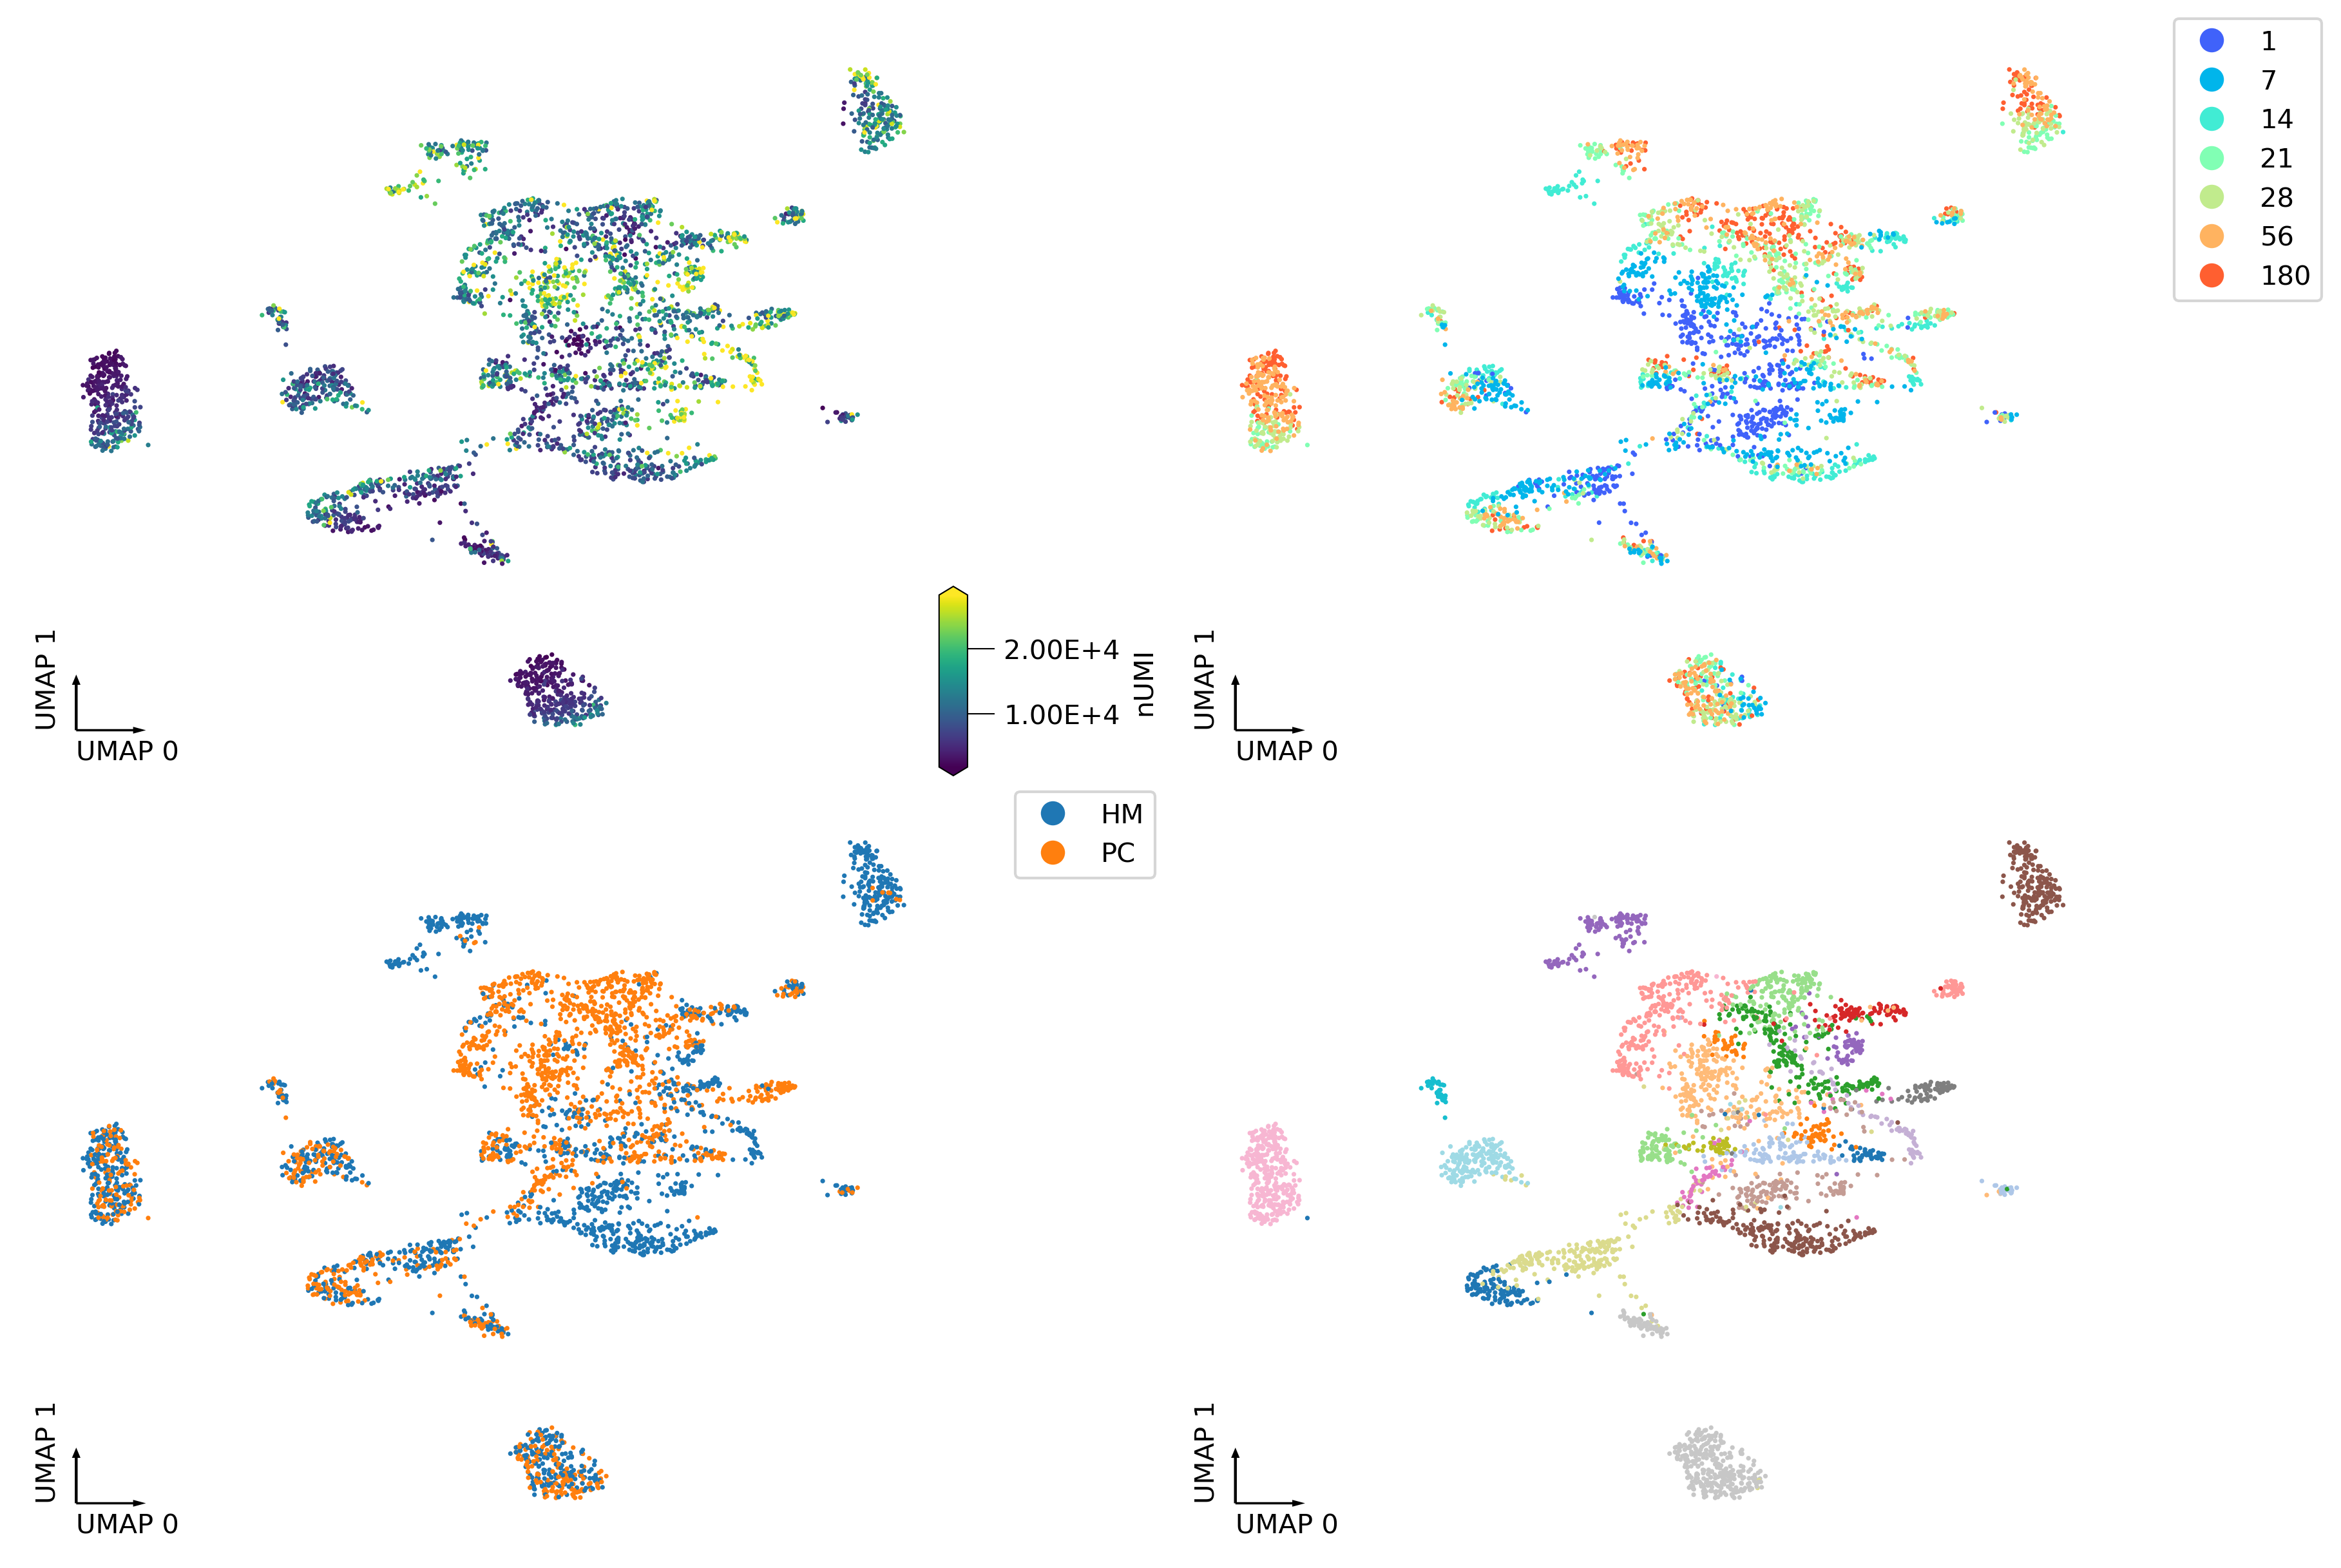

In [29]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=300, constrained_layout=True)
_ = continuous_scatter(ax=axes[0,0],
                       data=expr.obs,
                       hue='nUMI',
                       coord_base='umap',
                       max_points=None,
                       labelsize=10,
                       )
_ = categorical_scatter(data=expr.obs,
                        ax=axes[0,1],
                        coord_base='umap',
                        hue='age',
                        palette='rainbow',
                        labelsize=10,
                        show_legend=True)
_ = categorical_scatter(ax=axes[1,0],
                        data=expr.obs,
                        hue='region',
                        coord_base='umap',
                        # text_anno='region',
                        # palette='tab10',
                        labelsize=10,
                        show_legend=True
                       )
_ = categorical_scatter(ax=axes[1,1],
                        data=expr.obs,
                        hue='cluster',
                        coord_base='umap',
                        # text_anno='cluster',
                        palette='tab20',
                        labelsize=10,
                        # show_legend=True
                       )



In [30]:
gene3c

View of AnnData object with n_obs × n_vars = 3646 × 1999
    obs: 'tissue', 'treatment', 'age', 'sex', 'father', 'mother', 'restriction enzyme', 'cell-type cluster', 'contacts', 'umap_0', 'umap_1', 'leiden'
    var: 'chrom', 'source', 'feature', 'start', 'end', 'score', 'strand', 'phase', 'transcript_id', 'gene_type', 'gene_status', 'gene_name', 'transcript_type', 'transcript_status', 'transcript_name', 'exon_number', 'exon_id', 'level', 'mgi_id', 'havana_gene', 'tag', 'bin_len', 'weight', 'highly_variable'

In [31]:
sc.pp.regress_out(gene3c, ['contacts'])
sc.pp.scale(gene3c, max_value=10)


In [32]:
gene3c.obsm['X_pca'] = model.transform(gene3c.X) / model.singular_values_
gene3c.obsm['X_pca'] = normalize(gene3c.obsm['X_pca'][:, :30], axis=1)


In [33]:
expr.obs['Modality'] = 'RNA'
gene3c.obs['Modality'] = '3C'

In [34]:
adata_list = [expr, gene3c]


In [35]:
integrator = SeuratIntegration()

In [36]:
anchor = integrator.find_anchor(adata_list,
                                k_local=None,
                                key_local='X_pca',
                                k_anchor=5,
                                key_anchor='X',
                                dim_red='cca',
                                max_cc_cells=50000,
                                k_score=30,
                                k_filter=None,
                                scale1=False,
                                scale2=False,
                                #scale =[False, True]
                                n_components=30,
                                n_features=200,
                                alignments=[[[0], [1]]])


Find anchors across datasets.
Run CCA
non zero dims 30
Find Anchors using k=30
Score Anchors
Identified 6894 anchors between datasets 0 and 1.


In [37]:
start_time = time.time()
corrected = integrator.integrate(key_correct='X_pca',
                                 row_normalize=True,
                                 n_components=30,
                                 k_weight=100,
                                 sd=1,
                                 alignments=[[[0], [1]]])

print(time.time() - start_time)


Merge datasets
[[0], [1]]
Initialize
Find nearest anchors. k_weight:  100
Normalize graph
Transform data
6.461906433105469


In [38]:
ncell = np.sum([xx.shape[0] for xx in adata_list])
adata_merge = anndata.AnnData(
    X=np.ones((ncell, 1)), obs=pd.concat([xx.obs for xx in adata_list], axis=0)
)
adata_merge


AnnData object with n_obs × n_vars = 7163 × 1
    obs: 'Genes', 'nUMI', 'umap_0', 'umap_1', 'age', 'region', 'cluster', 'Modality', 'tissue', 'treatment', 'sex', 'father', 'mother', 'restriction enzyme', 'cell-type cluster', 'contacts', 'leiden'

In [39]:
adata_merge.obsm['u30_seuratcc30nofilter'] = np.concatenate(corrected, axis=0)
adata_merge.obsm['X_pca'] = normalize(adata_merge.obsm['u30_seuratcc30nofilter'][:, :30], axis=1)
# sce.pp.harmony_integrate(adata_merge, 'Modality', max_iter_harmony=30, random_state=0)
# adata_merge.obsm['log_reghvg_cca_u25hm'] = adata_merge.obsm['X_pca_harmony'].copy()


In [40]:
knn = 25
sc.pp.neighbors(adata_merge, n_neighbors=knn, use_rep='u30_seuratcc30nofilter')
sc.tl.umap(adata_merge, maxiter=200, random_state=0)
adata_merge = dump_embedding(adata_merge, 'umap')
adata_merge.obsm['u30_seuratcc30nofilter_u30_umap'] = adata_merge.obsm['X_umap'].copy()


In [42]:
legage = np.sort(adata_merge.obs['age'].unique())
palage = {xx:yy for xx,yy in zip(legage, sns.color_palette('hls', len(legage)))}


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica


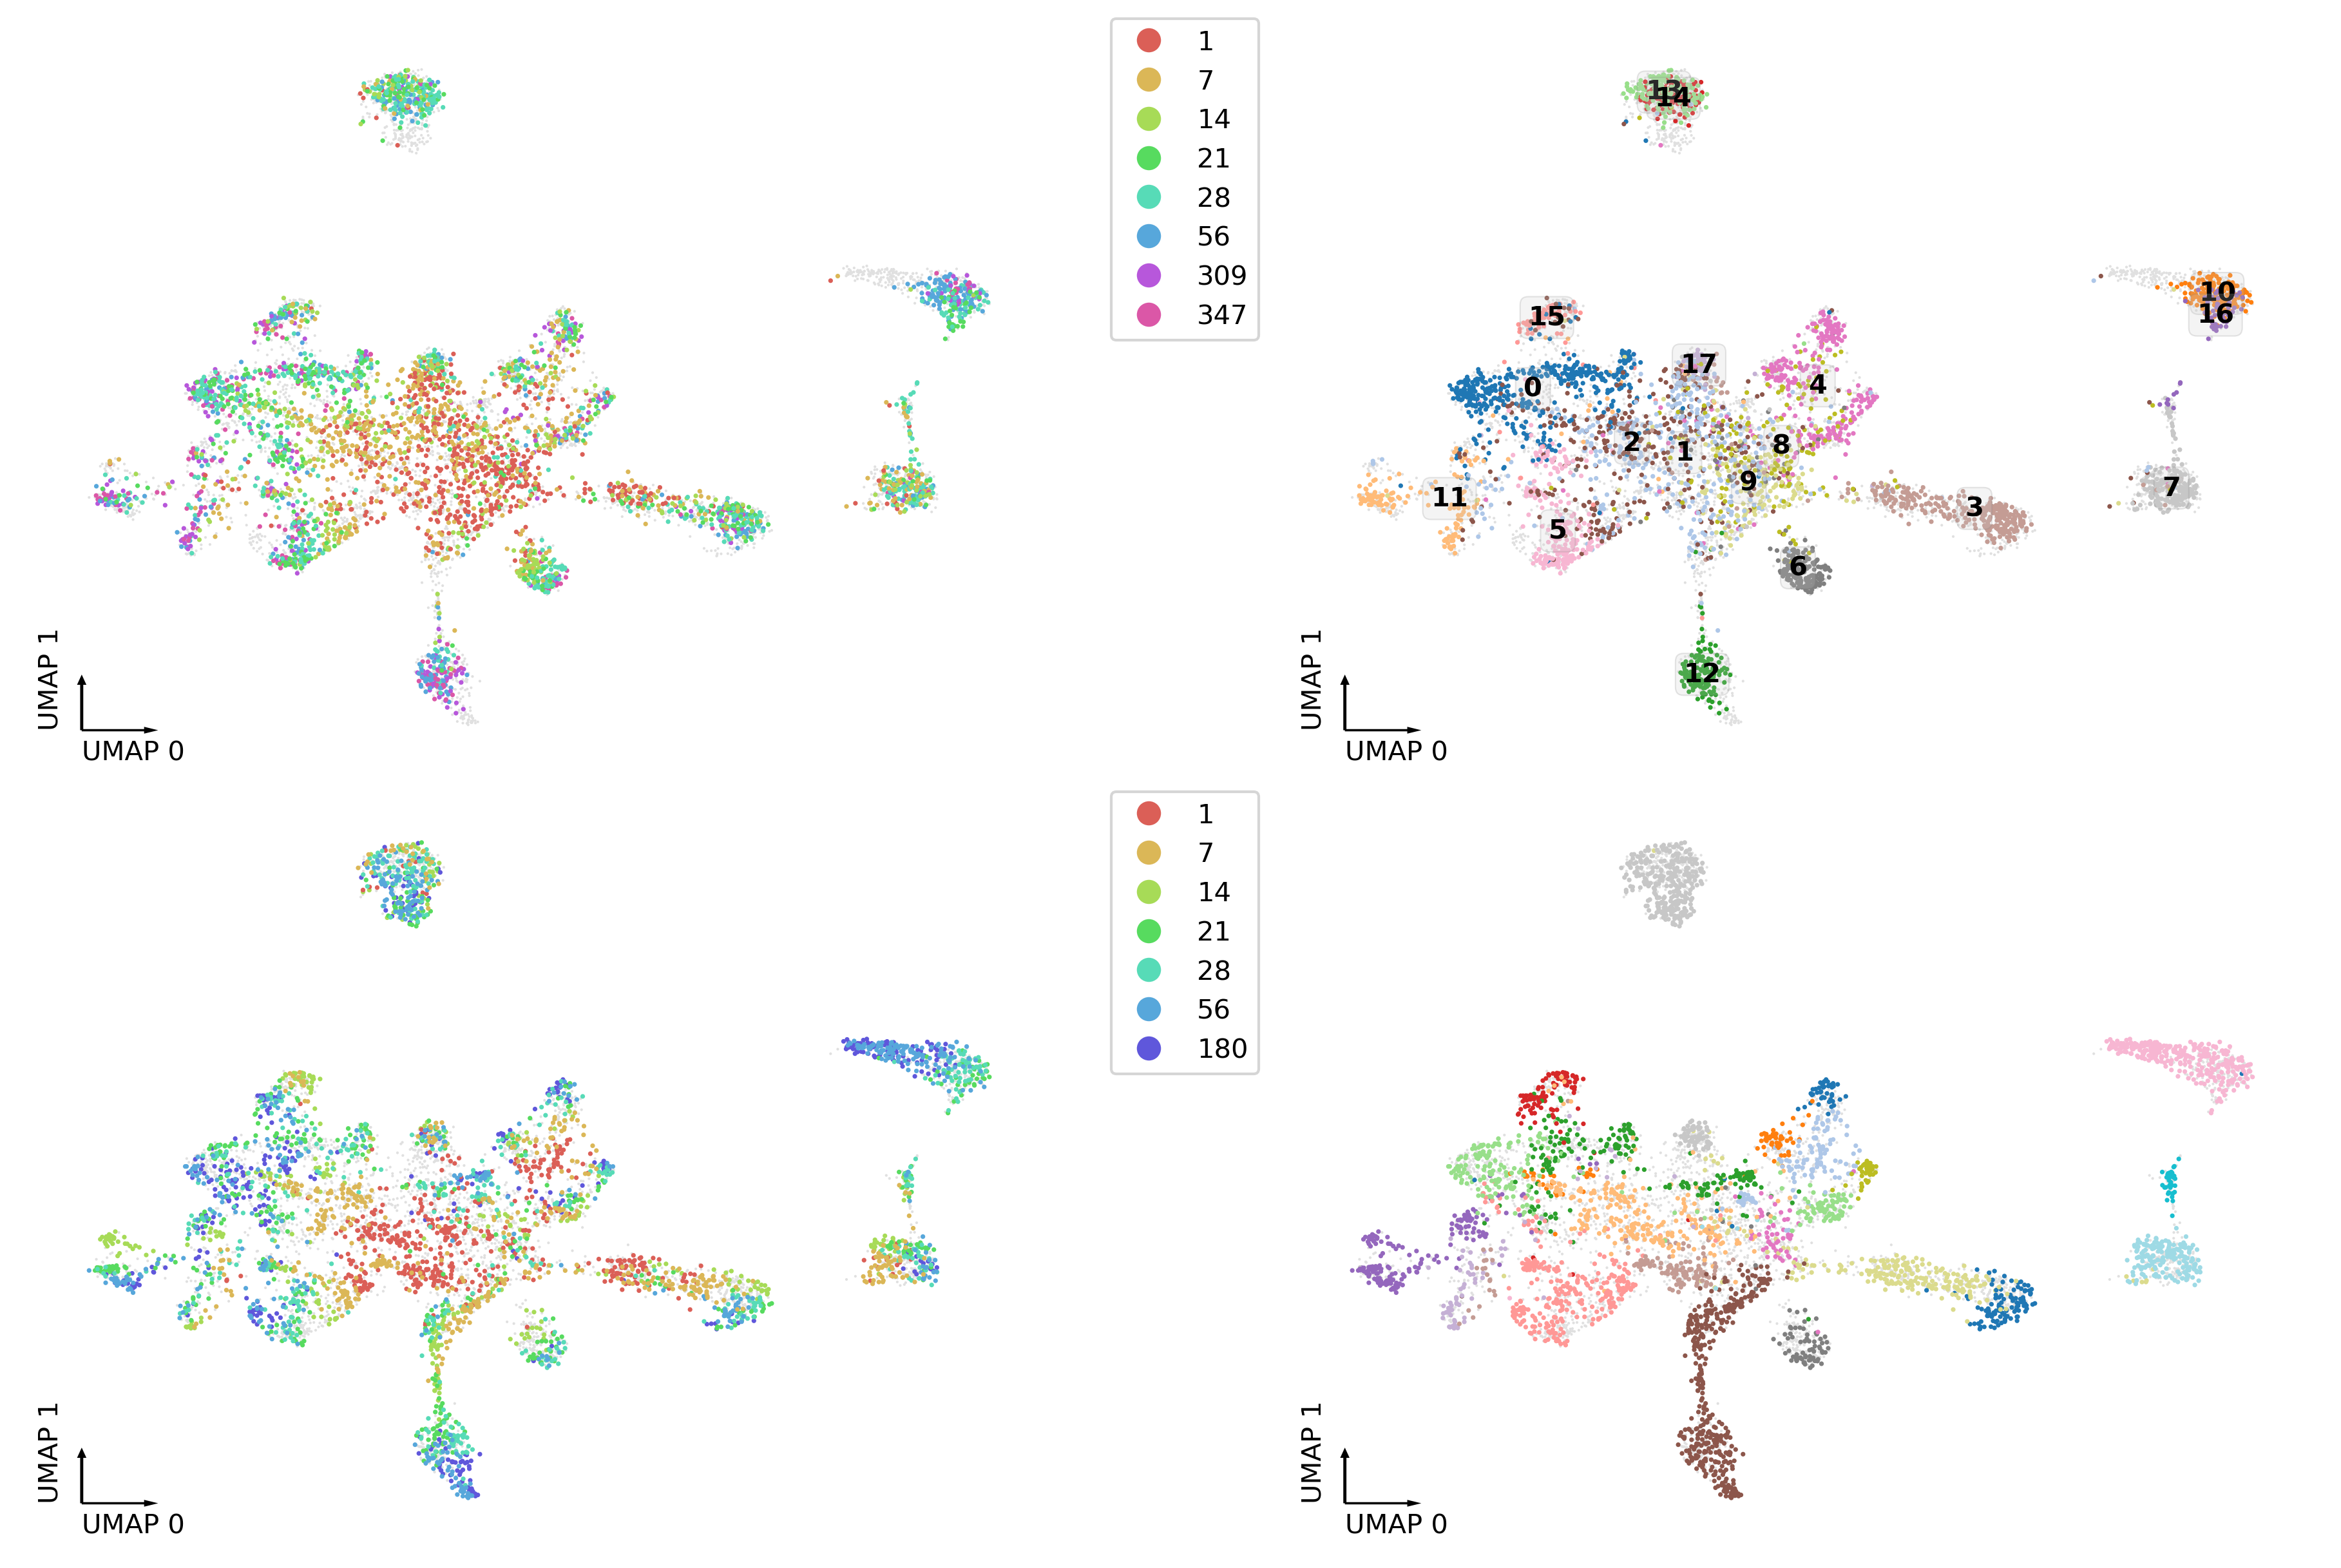

In [44]:
# adata_merge.obsm['X_umap'] = adata_merge.obsm['u50_seuratcc30nofilter_u30_umap'].copy()
# dump_embedding(adata_merge, 'umap')

fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=300, constrained_layout=True)
tmp = adata_merge.obs.loc[adata_merge.obs['Modality']=='3C']
ax = axes[0,0]
ax.scatter(adata_merge.obs['umap_0'], adata_merge.obs['umap_1'], c='#e0e0e0', edgecolors='none', s=1, rasterized=True)
_ = categorical_scatter(data=tmp,
                        ax=ax,
                        coord_base='umap',
                        hue='age',
                        palette=palage,
                        labelsize=10,
                        show_legend=True)

ax = axes[0,1]
ax.scatter(adata_merge.obs['umap_0'], adata_merge.obs['umap_1'], c='#e0e0e0', edgecolors='none', s=1, rasterized=True)
_ = categorical_scatter(data=tmp,
                        ax=ax,
                        coord_base='umap',
                        hue='leiden',
                        text_anno='leiden',
                        palette='tab20',
                        labelsize=10,
                        #show_legend=True
                       )

tmp = adata_merge.obs.loc[adata_merge.obs['Modality']=='RNA']
ax = axes[1,0]
ax.scatter(adata_merge.obs['umap_0'], adata_merge.obs['umap_1'], c='#e0e0e0', edgecolors='none', s=1, rasterized=True)
_ = categorical_scatter(data=tmp,
                        ax=ax,
                        coord_base='umap',
                        hue='age',
                        palette=palage,
                        labelsize=10,
                        show_legend=True)

ax = axes[1,1]
ax.scatter(adata_merge.obs['umap_0'], adata_merge.obs['umap_1'], c='#e0e0e0', edgecolors='none', s=1, rasterized=True)
_ = categorical_scatter(data=tmp,
                        ax=ax,
                        coord_base='umap',
                        hue='cluster',
                        # text_anno='cluster',
                        palette='tab20',
                        labelsize=10,
                        #show_legend=True
                       )




In [45]:
adata_merge.obs.loc[:,adata_merge.obs.dtypes == 'object'] = adata_merge.obs.loc[:,adata_merge.obs.dtypes == 'object'].astype(str)
adata_merge.write_h5ad('Tan2021_rna3c.h5ad')


In [46]:
rna_cell = (adata_merge.obs['Modality']=='RNA')
hic_cell = (adata_merge.obs['Modality']=='3C')
print(rna_cell.sum(), hic_cell.sum())

start_time = time.time()
index = pynndescent.NNDescent(adata_merge.obsm['X_pca'][rna_cell], metric='euclidean', n_neighbors=50, random_state=0, n_jobs=-1)
print(time.time() - start_time)
G, D = index.query(adata_merge.obsm['X_pca'][hic_cell], k=15)
print(time.time() - start_time)


3517 3646
0.7463104724884033
2.10052227973938


In [47]:
chunk_size = 50000
sd = 1
start_time = time.time()
cellfilter = D[:, -1] == 0
D = 1 - D / D[:, -1][:, None]
D[cellfilter] = 1
D = 1 - np.exp(-D * (sd**2) / 4)
D = D / (np.sum(D, axis=1) + 1e-6)[:, None]
print(time.time() - start_time)


0.0013263225555419922


In [48]:
rna_cell = rna_cell.index[rna_cell]
hic_cell = hic_cell.index[hic_cell]


In [49]:
enc = OneHotEncoder()
# enc.fit(adata_merge.obs.loc[aibs_cell, ['L3']].values.astype(str))
labelref = enc.fit_transform(adata_merge.obs.loc[rna_cell, 'cluster'].astype(str)[:, None])
cluster = pd.DataFrame(index=hic_cell, columns=['rnatype', 'score'], dtype=str)
for chunk_start in range(0, len(hic_cell), chunk_size):
    result = (
        D[chunk_start : (chunk_start + chunk_size), :, None]
        * labelref[G[chunk_start : (chunk_start + chunk_size)].flatten()]
        .toarray()
        .reshape((-1, 15, enc.categories_[0].shape[0]))
    ).sum(axis=1)
    result = pd.DataFrame(
        result,
        columns=enc.categories_[0],
        index=hic_cell[chunk_start : (chunk_start + chunk_size)],
    )
    result = result.loc[:, result.columns != "nan"]
    cluster.loc[result.index, "rnatype"] = result.idxmax(axis=1).values
    cluster.loc[result.index, "score"] = result.max(axis=1).values
    print(chunk_start)

print(time.time() - start_time)
cluster.to_hdf("DipC_rnacluster.hdf", key="data")


0
0.6793961524963379


In [50]:
cluster['dipctype'] = adata_merge.obs.loc[hic_cell, 'cell-type cluster']
adata_merge.obs.loc[hic_cell, 'cluster'] = cluster['rnatype']

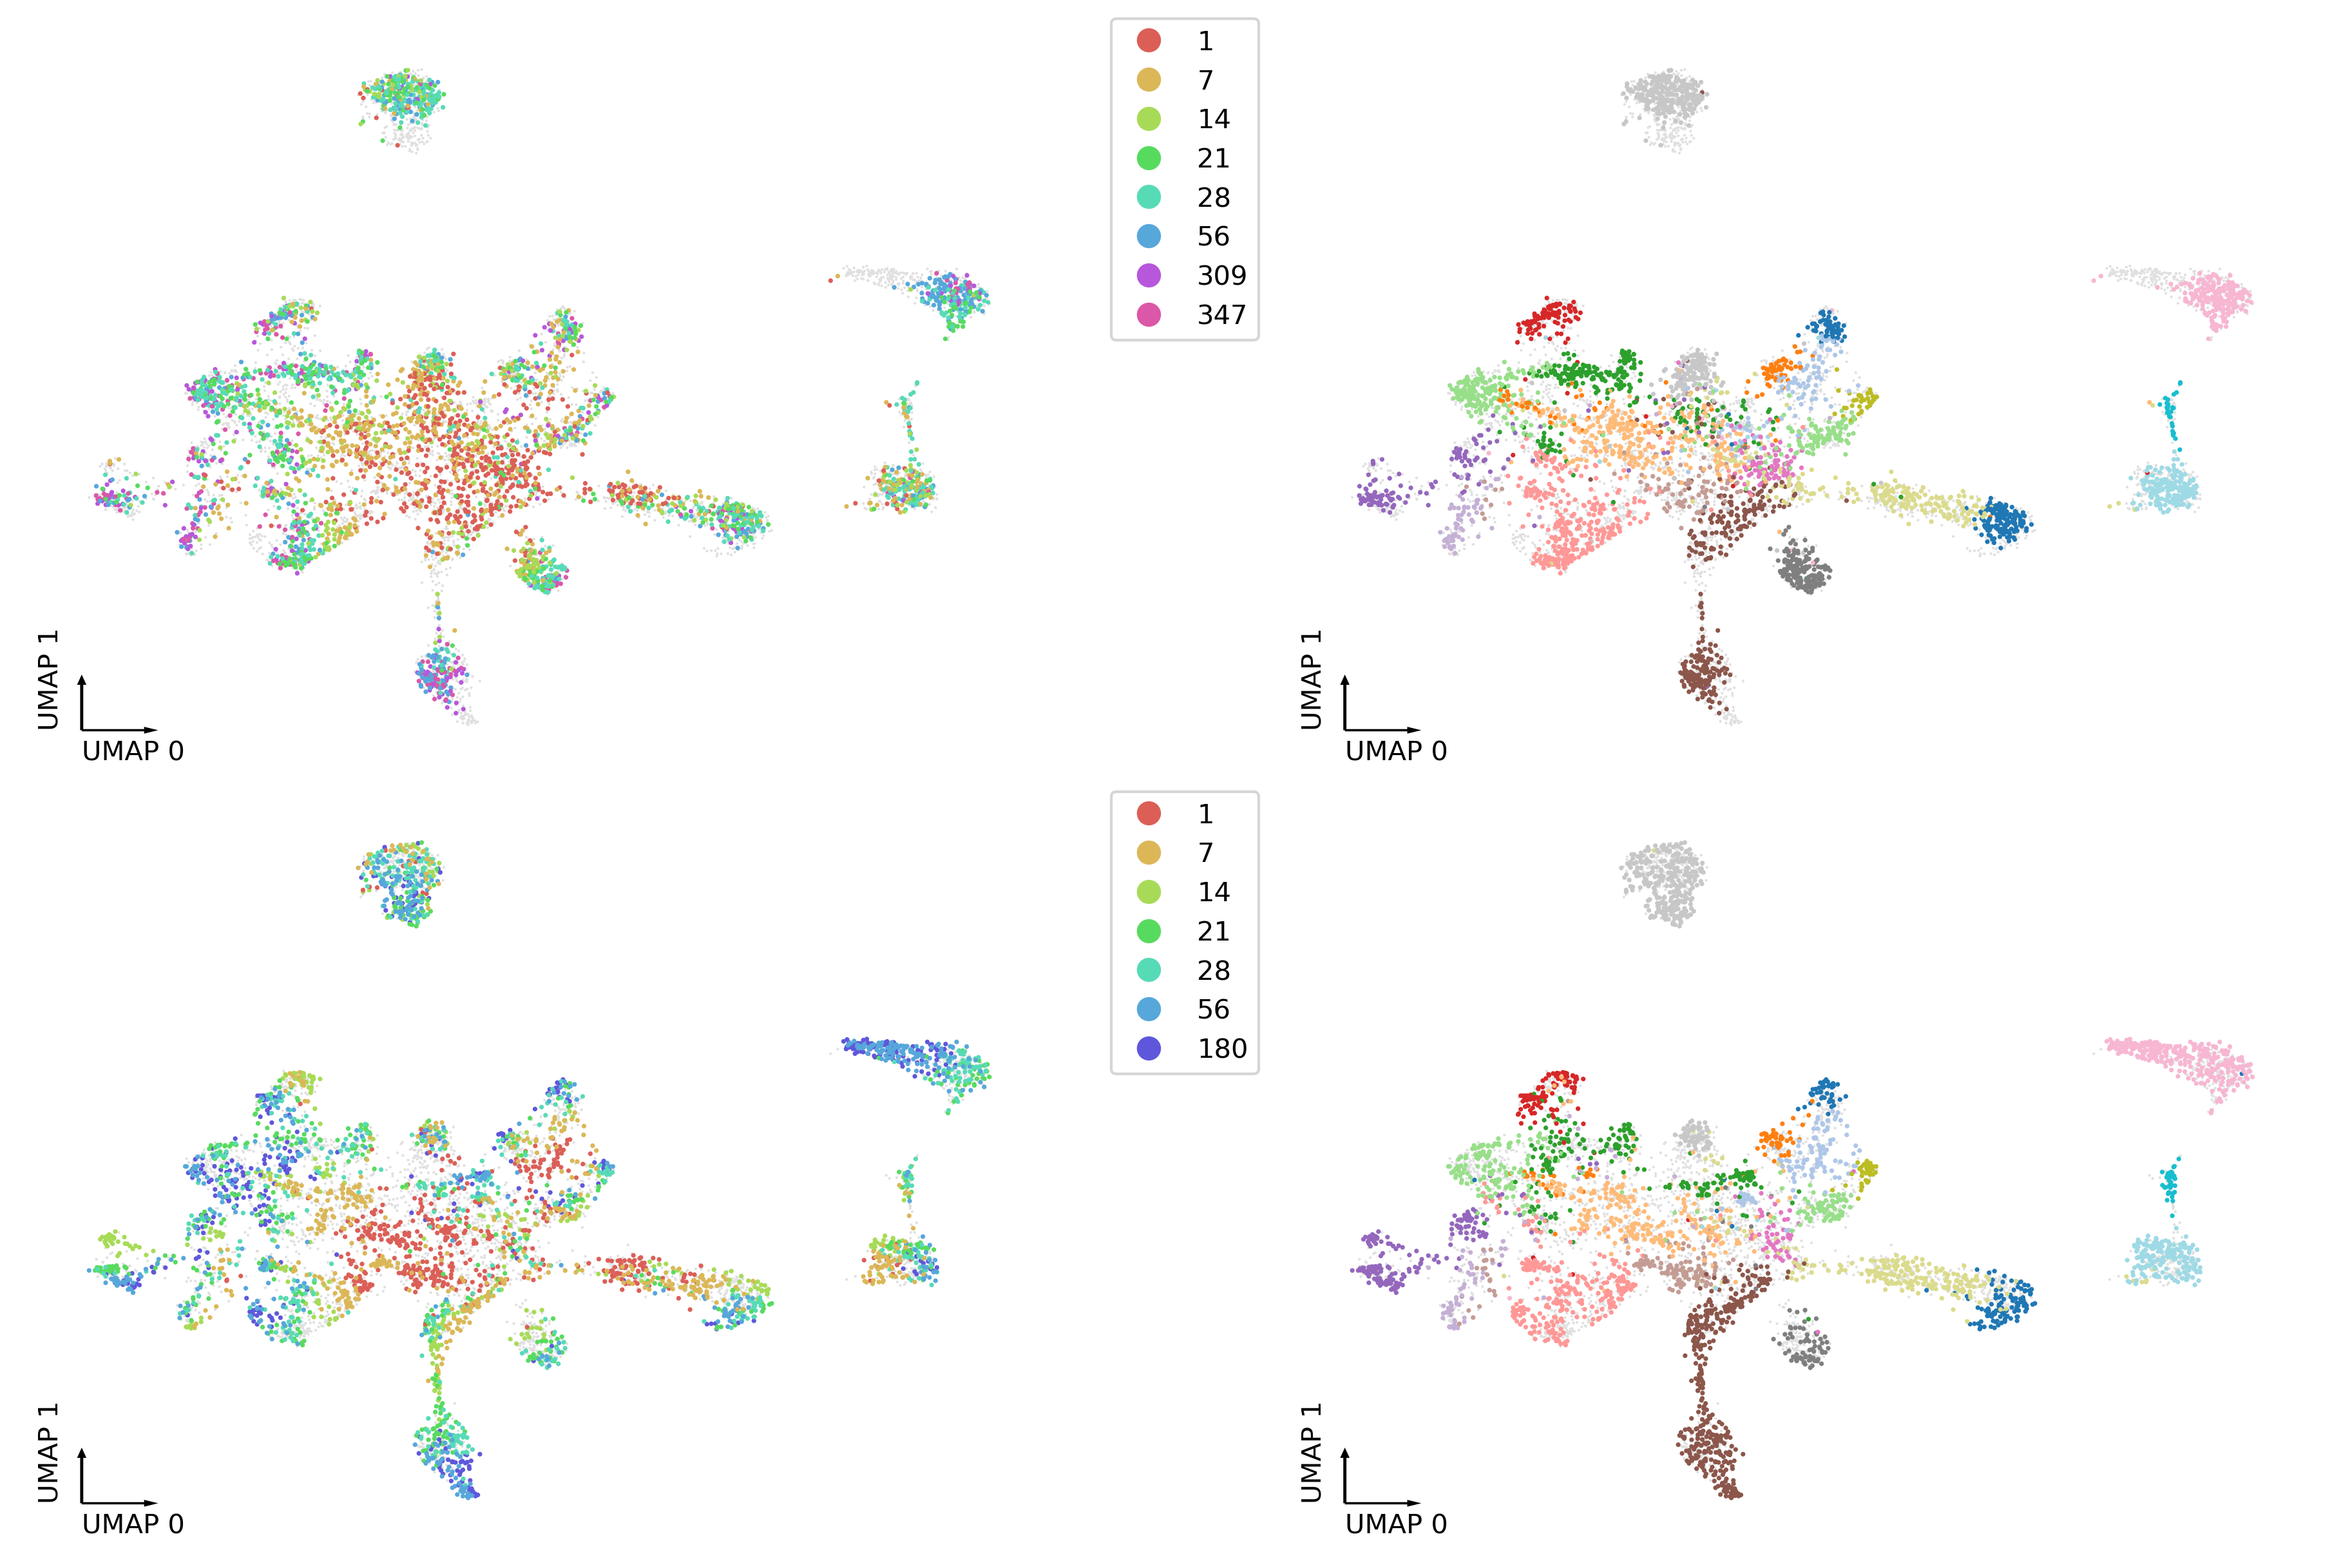

In [51]:
# adata_merge.obsm['X_umap'] = adata_merge.obsm['u50_seuratcc30nofilter_u30_umap'].copy()
# dump_embedding(adata_merge, 'umap')

fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=300, constrained_layout=True)
tmp = adata_merge.obs.loc[adata_merge.obs['Modality']=='3C']
ax = axes[0,0]
ax.scatter(adata_merge.obs['umap_0'], adata_merge.obs['umap_1'], c='#e0e0e0', edgecolors='none', s=1, rasterized=True)
_ = categorical_scatter(data=tmp,
                        ax=ax,
                        coord_base='umap',
                        hue='age',
                        palette=palage,
                        labelsize=10,
                        show_legend=True)

ax = axes[0,1]
ax.scatter(adata_merge.obs['umap_0'], adata_merge.obs['umap_1'], c='#e0e0e0', edgecolors='none', s=1, rasterized=True)
_ = categorical_scatter(data=tmp,
                        ax=ax,
                        coord_base='umap',
                        hue='cluster',
                        # text_anno='celltype',
                        palette='tab20',
                        labelsize=10,
                        #show_legend=True
                       )

tmp = adata_merge.obs.loc[adata_merge.obs['Modality']=='RNA']
ax = axes[1,0]
ax.scatter(adata_merge.obs['umap_0'], adata_merge.obs['umap_1'], c='#e0e0e0', edgecolors='none', s=1, rasterized=True)
_ = categorical_scatter(data=tmp,
                        ax=ax,
                        coord_base='umap',
                        hue='age',
                        palette=palage,
                        labelsize=10,
                        show_legend=True)

ax = axes[1,1]
ax.scatter(adata_merge.obs['umap_0'], adata_merge.obs['umap_1'], c='#e0e0e0', edgecolors='none', s=1, rasterized=True)
_ = categorical_scatter(data=tmp,
                        ax=ax,
                        coord_base='umap',
                        hue='cluster',
                        # text_anno='cluster',
                        palette='tab20',
                        labelsize=10,
                        #show_legend=True
                       )


In [52]:
cf_matrix = cluster[['dipctype','rnatype']].value_counts().unstack().fillna(0)
cf_matrix = cf_matrix / np.sqrt(cf_matrix.sum(axis=1)[:,None]) / np.sqrt(cf_matrix.sum(axis=0))

In [53]:
idx = pd.Series(np.arange(cf_matrix.shape[1]), cf_matrix.columns)

<AxesSubplot:xlabel='rnatype', ylabel='dipctype'>

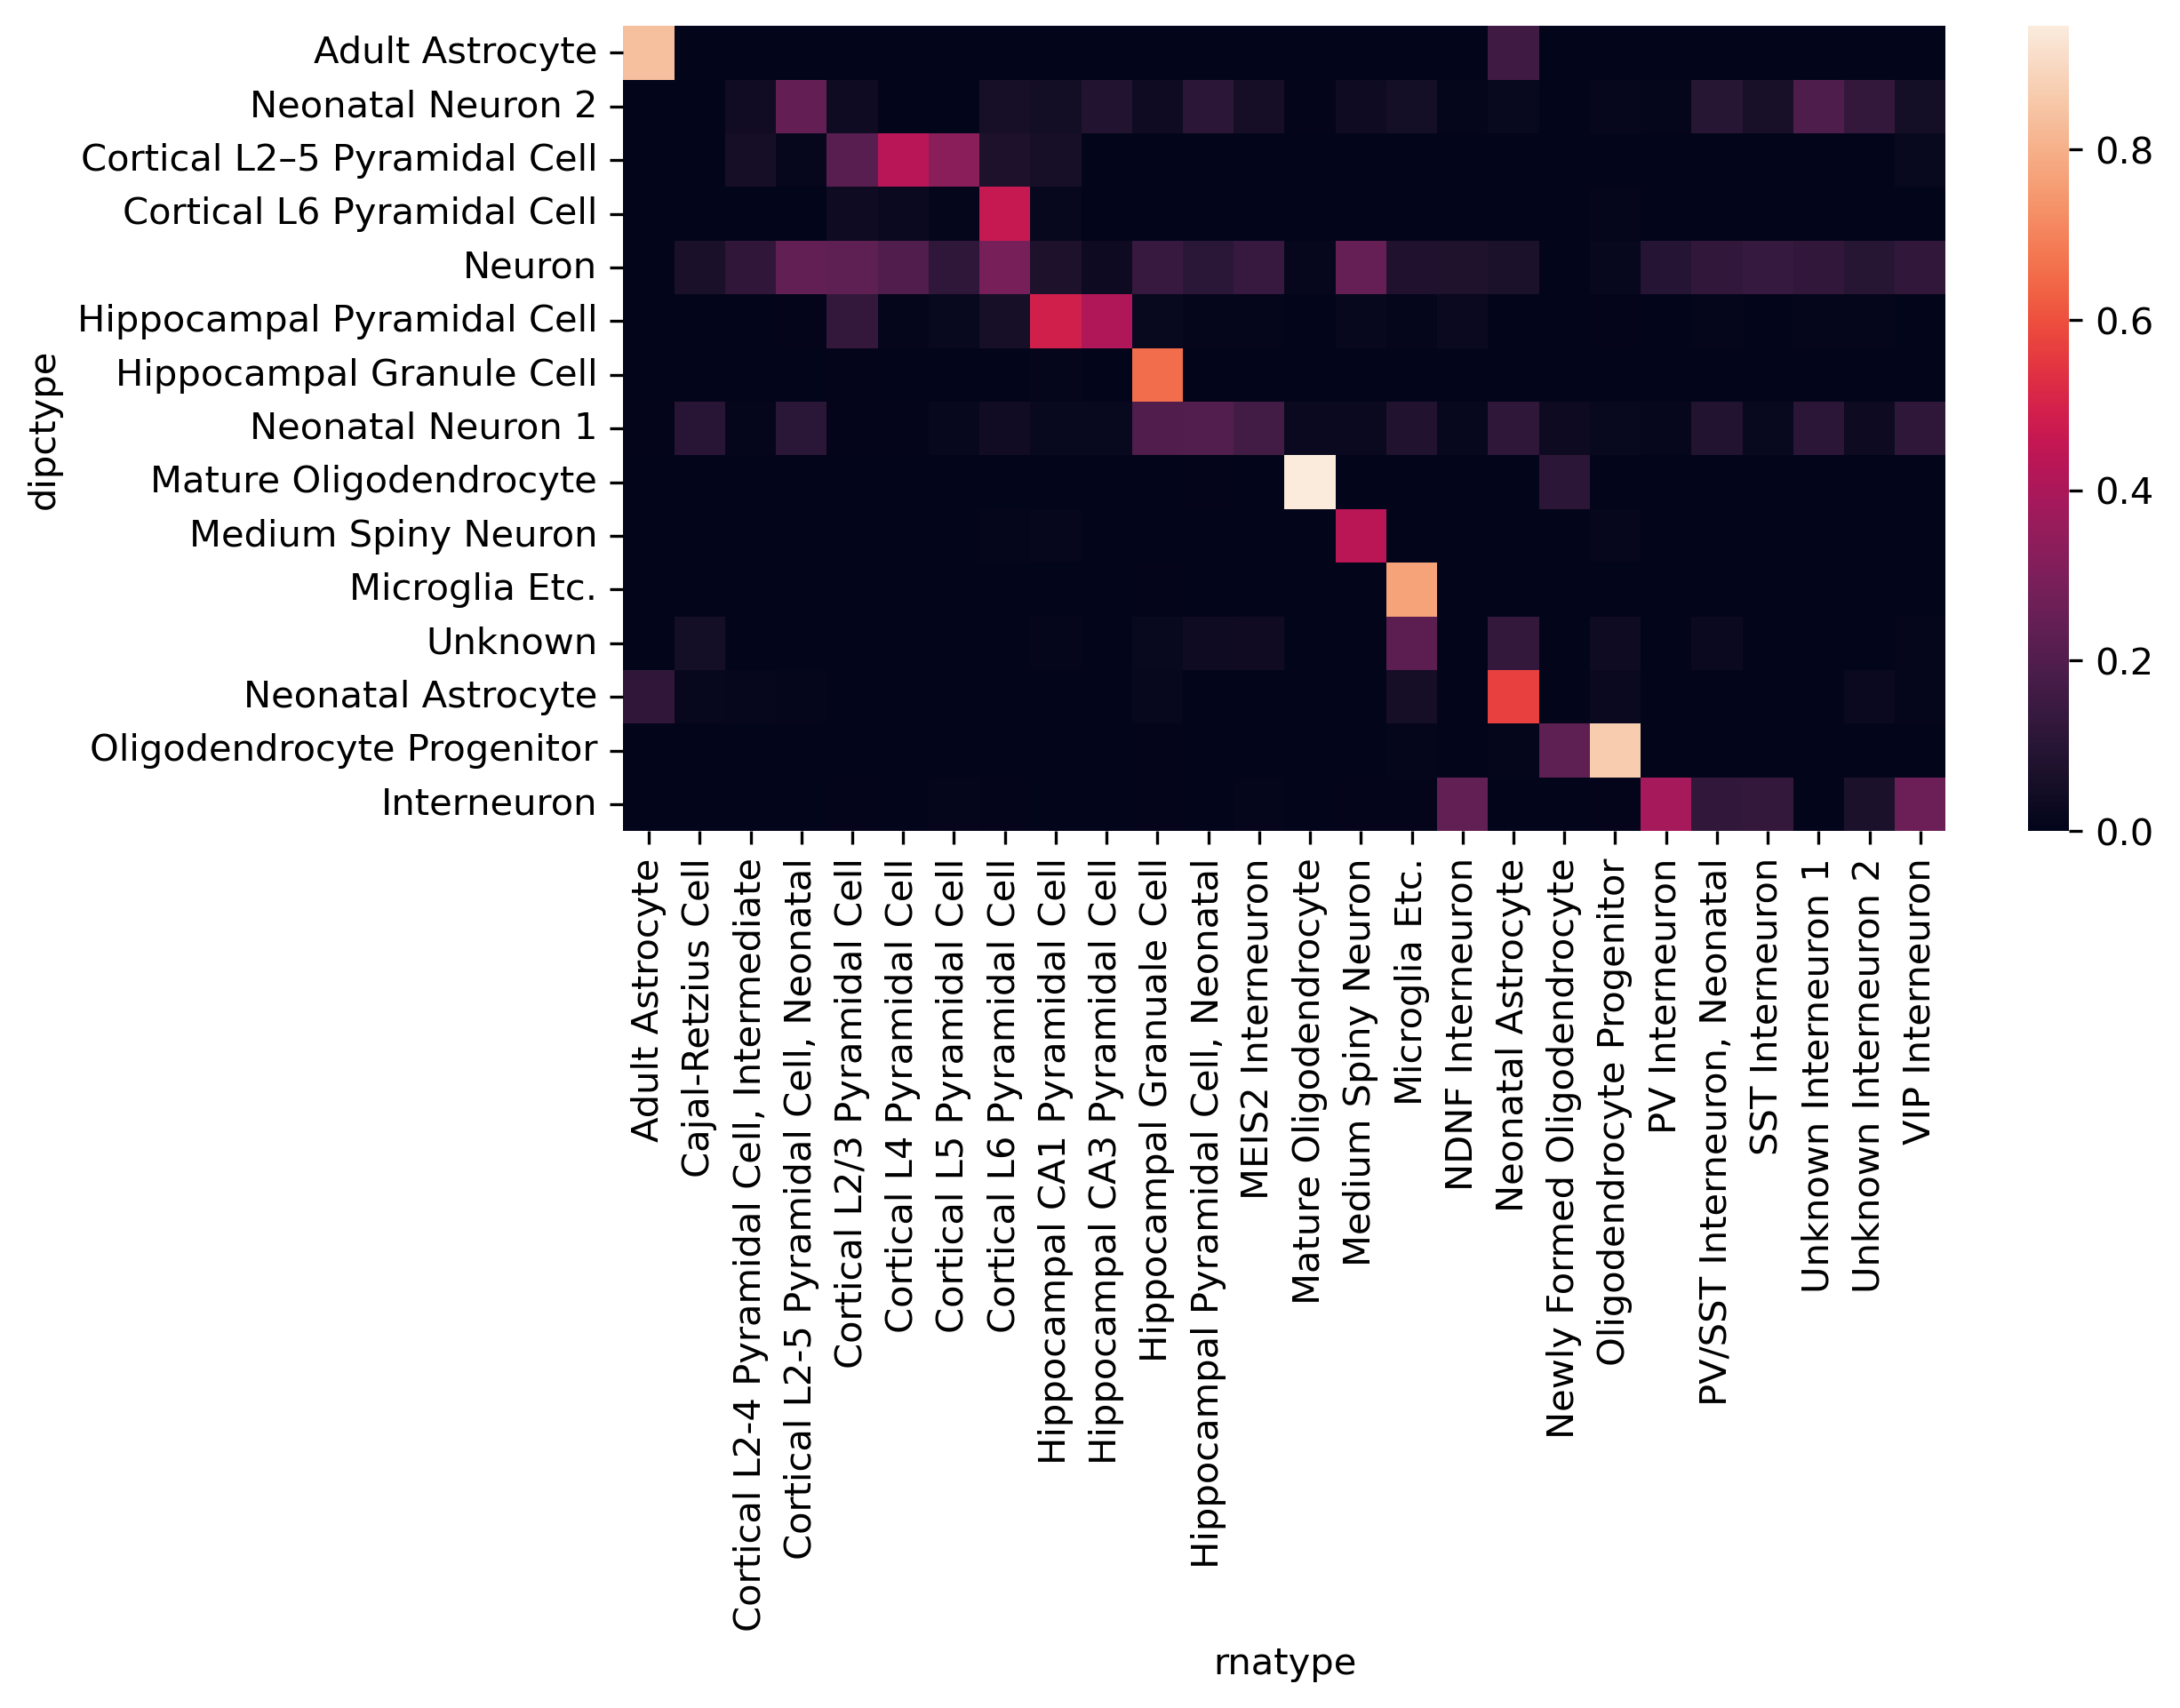

In [54]:
fig, ax = plt.subplots(figsize=(8,4), dpi=300)
sns.heatmap(cf_matrix.iloc[np.argsort(idx[np.argmax(cf_matrix.values, axis=1)])], ax=ax)


In [55]:
cluster['rnatype'].value_counts()

Microglia Etc.                                391
Cortical L6 Pyramidal Cell                    333
Hippocampal Granuale Cell                     309
Neonatal Astrocyte                            234
Cortical L2-5 Pyramidal Cell, Neonatal        211
Mature Oligodendrocyte                        210
Cortical L2/3 Pyramidal Cell                  204
Cortical L4 Pyramidal Cell                    195
Oligodendrocyte Progenitor                    189
Medium Spiny Neuron                           167
Adult Astrocyte                               144
Hippocampal CA1 Pyramidal Cell                134
VIP Interneuron                               112
Cortical L5 Pyramidal Cell                     98
Hippocampal Pyramidal Cell, Neonatal           93
Unknown Interneuron 1                          89
MEIS2 Interneuron                              88
PV/SST Interneuron, Neonatal                   85
Hippocampal CA3 Pyramidal Cell                 70
PV Interneuron                                 61


In [64]:
cluster.to_csv('Tan2021_dipc_cluster.csv.gz', )

rnatype     score  \
cortex-p028-cb_116                 Cortical L6 Pyramidal Cell  0.999996   
cortex-visual-control-p007-b6_182  Cortical L6 Pyramidal Cell  0.999992   
cortex-p028-cb_112                 Cortical L6 Pyramidal Cell  0.999996   
cortex-visual-control-p001-b6_061       Unknown Interneuron 2  0.330496   
cortex-p056-cb_216                             Microglia Etc.  0.999989   
...                                                       ...       ...   
cortex-visual-control-p021-b6_090      Mature Oligodendrocyte  0.999994   
cortex-visual-control-p021-b6_012  Cortical L6 Pyramidal Cell  0.999997   
hippocampus-p007-cb_046                        Microglia Etc.  0.999993   
cortex-visual-dark-p014-b6_106                 Microglia Etc.  0.999994   
cortex-visual-control-p021-b6_174              Microglia Etc.  0.999995   

                                                       dipctype dipcleiden  
cortex-p028-cb_116                   Cortical L6 Pyramidal Cell          5  
cortex-visual-control-p007-b6_182                        Neuron          2  
cortex-p028-cb_112                 Cortical L2–5 Pyramidal Cell          5  
cortex-visual-control-p001-b6_061                        Neuron          2  
cortex-p056-cb_216                               Microglia Etc.         14  
...                                                         ...        ...  
cortex-visual-control-p021-b6_090        Mature Oligodendrocyte         16  
cortex-visual-control-p021-b6_012                        Neuron          5  
hippocampus-p007-cb_046                          Microglia Etc.         13  
cortex-visual-dark-p014-b6_106                   Microglia Etc.         13  
cortex-visual-control-p021-b6_174                Microglia Etc.         13  

[3646 rows x 4 columns]

In [56]:
cluster['dipcleiden'] = adata_merge.obs.loc[hic_cell, 'leiden']
cf_matrix = cluster[['dipcleiden','rnatype']].value_counts().unstack().fillna(0)
cf_matrix = cf_matrix / np.sqrt(cf_matrix.sum(axis=1)[:,None]) / np.sqrt(cf_matrix.sum(axis=0))
idx = pd.Series(np.arange(cf_matrix.shape[1]), cf_matrix.columns)


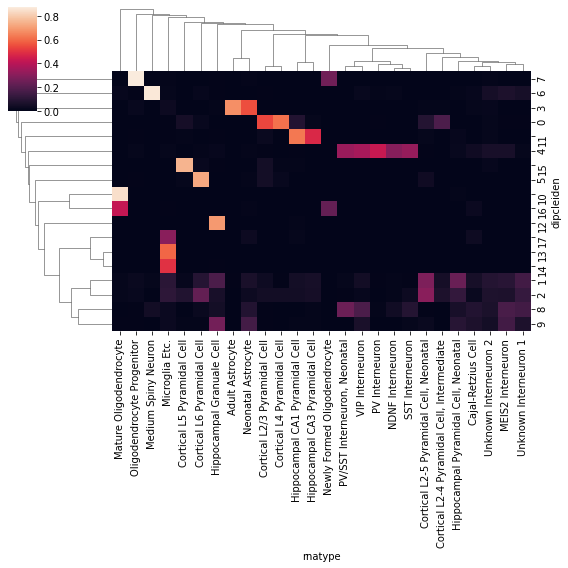

In [63]:
sns.clustermap(cf_matrix, figsize=(8,8))
